In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Segmentation

--------------

## Separating an image into one or more regions of interest.

Everyone has heard or seen Photoshop or a similar graphics editor take a person from one image and place them into another.  The first step of doing this is *identifying where that person is in the source image*.

In popular culture, the Terminator's vision segments humans:

<img src="../workshops/2014-scipy/images/terminator-vision.png" width="700px"/>

### Segmentation contains two major sub-fields

* **Supervised** segmentation: Some prior knowledge, possibly from human input, is used to guide the algorithm.  Supervised algorithms currently included in scikit-image include
  *  Thresholding algorithms which require user input (`skimage.filters.threshold_*`)
  * `skimage.segmentation.random_walker`
  * `skimage.segmentation.active_contour`
  * `skimage.segmentation.watershed`
* **Unsupervised** segmentation: No prior knowledge.  These algorithms attempt to subdivide into meaningful regions automatically.  The user may be able to tweak settings like number of regions.
  *  Thresholding algorithms which require no user input.
  *  `skimage.segmentation.slic`
  * `skimage.segmentation.chan_vese`
  * `skimage.segmentation.felzenszwalb`
  * `skimage.segmentation.quickshift`


First, some standard imports and a helper function to display our results

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color


def image_show(image, nrows=1, ncols=1, cmap='gray', **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

## Thresholding

In some images, global or local contrast may be sufficient to separate regions of interest.  Simply choosing all pixels above or below a certain *threshold* may be sufficient to segment such an image.

Let's try this on an image of a textbook.

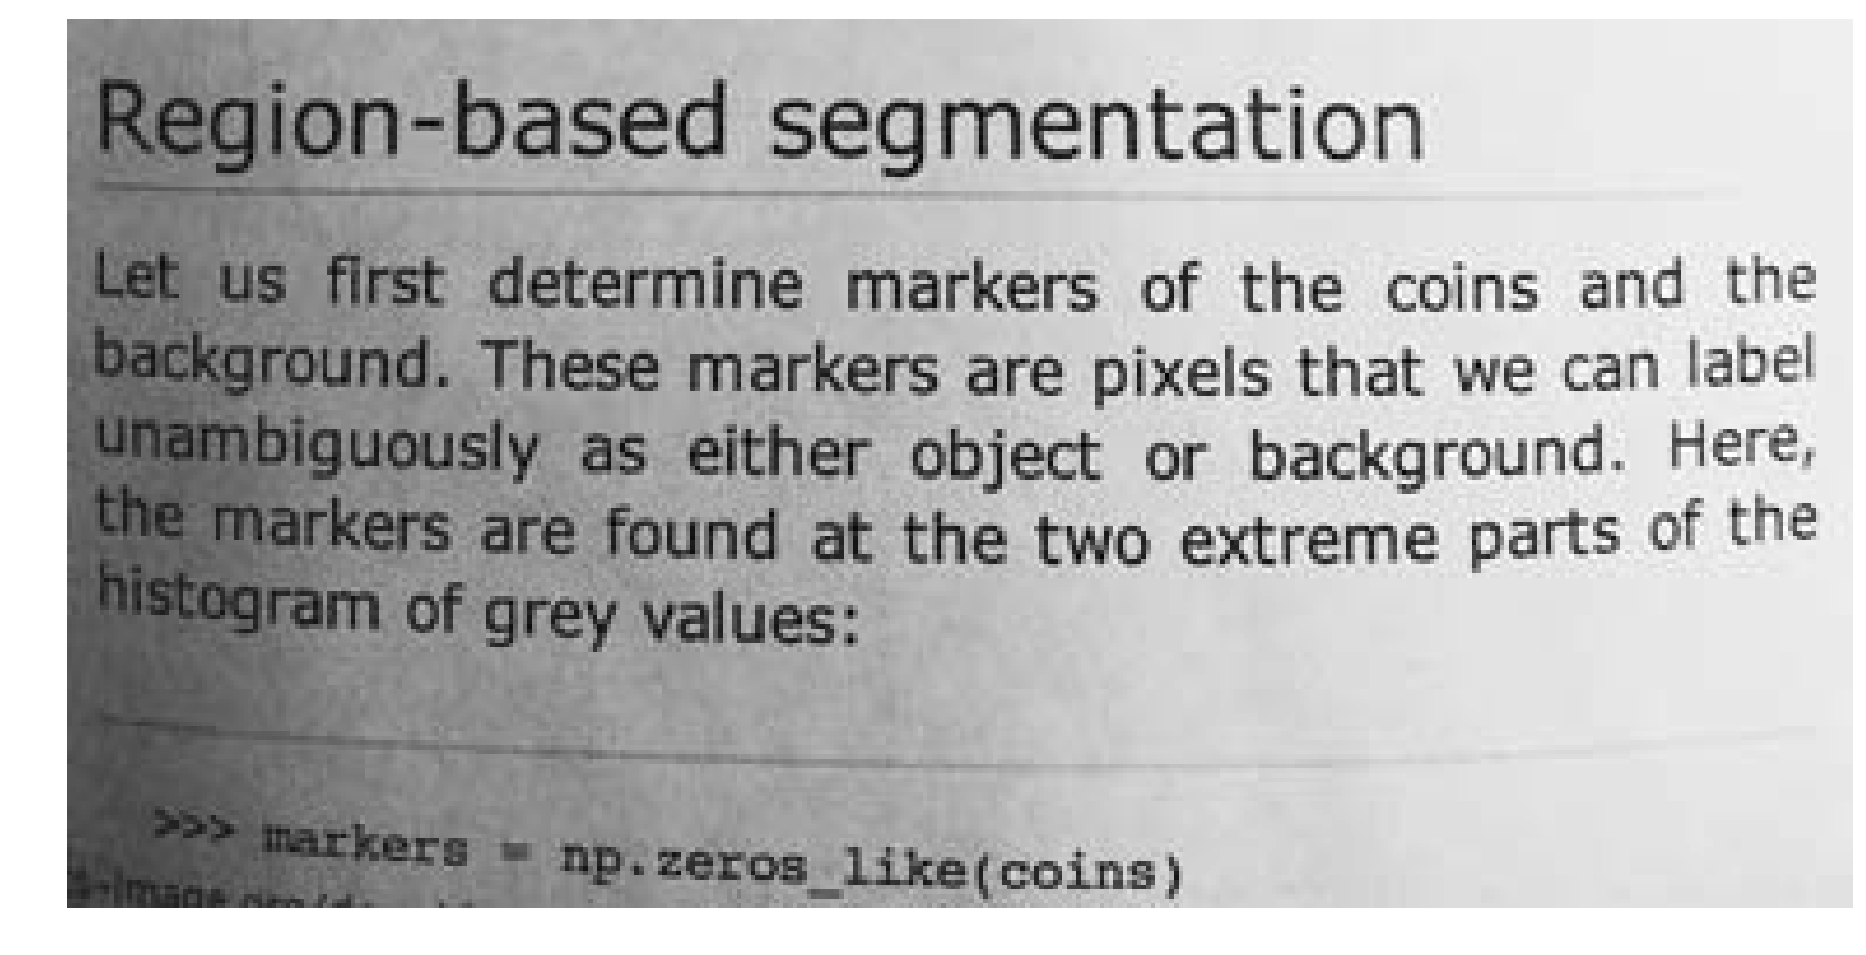

In [3]:
text = data.page()

image_show(text);

### Histograms

A histogram simply plots the frequency (number of times) values within a certain range appear against the data values themselves.  It is a powerful tool to get to know your data - or decide where you would like to threshold.

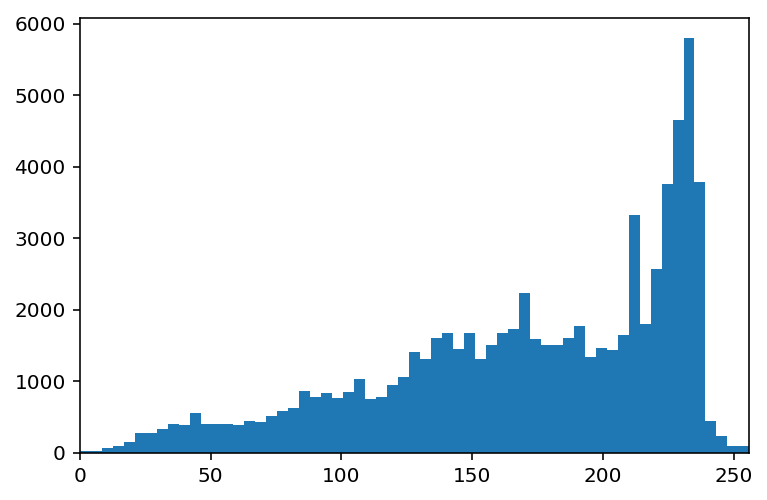

In [4]:
fig, ax = plt.subplots(1, 1)
ax.hist(text.ravel(), bins='auto', range=[0, 256])
ax.set_xlim(0, 256);

### Experimentation: supervised thresholding

Try simple NumPy methods and a few different thresholds on this image.  Because *we* are setting the threshold, this is *supervised* segmentation.

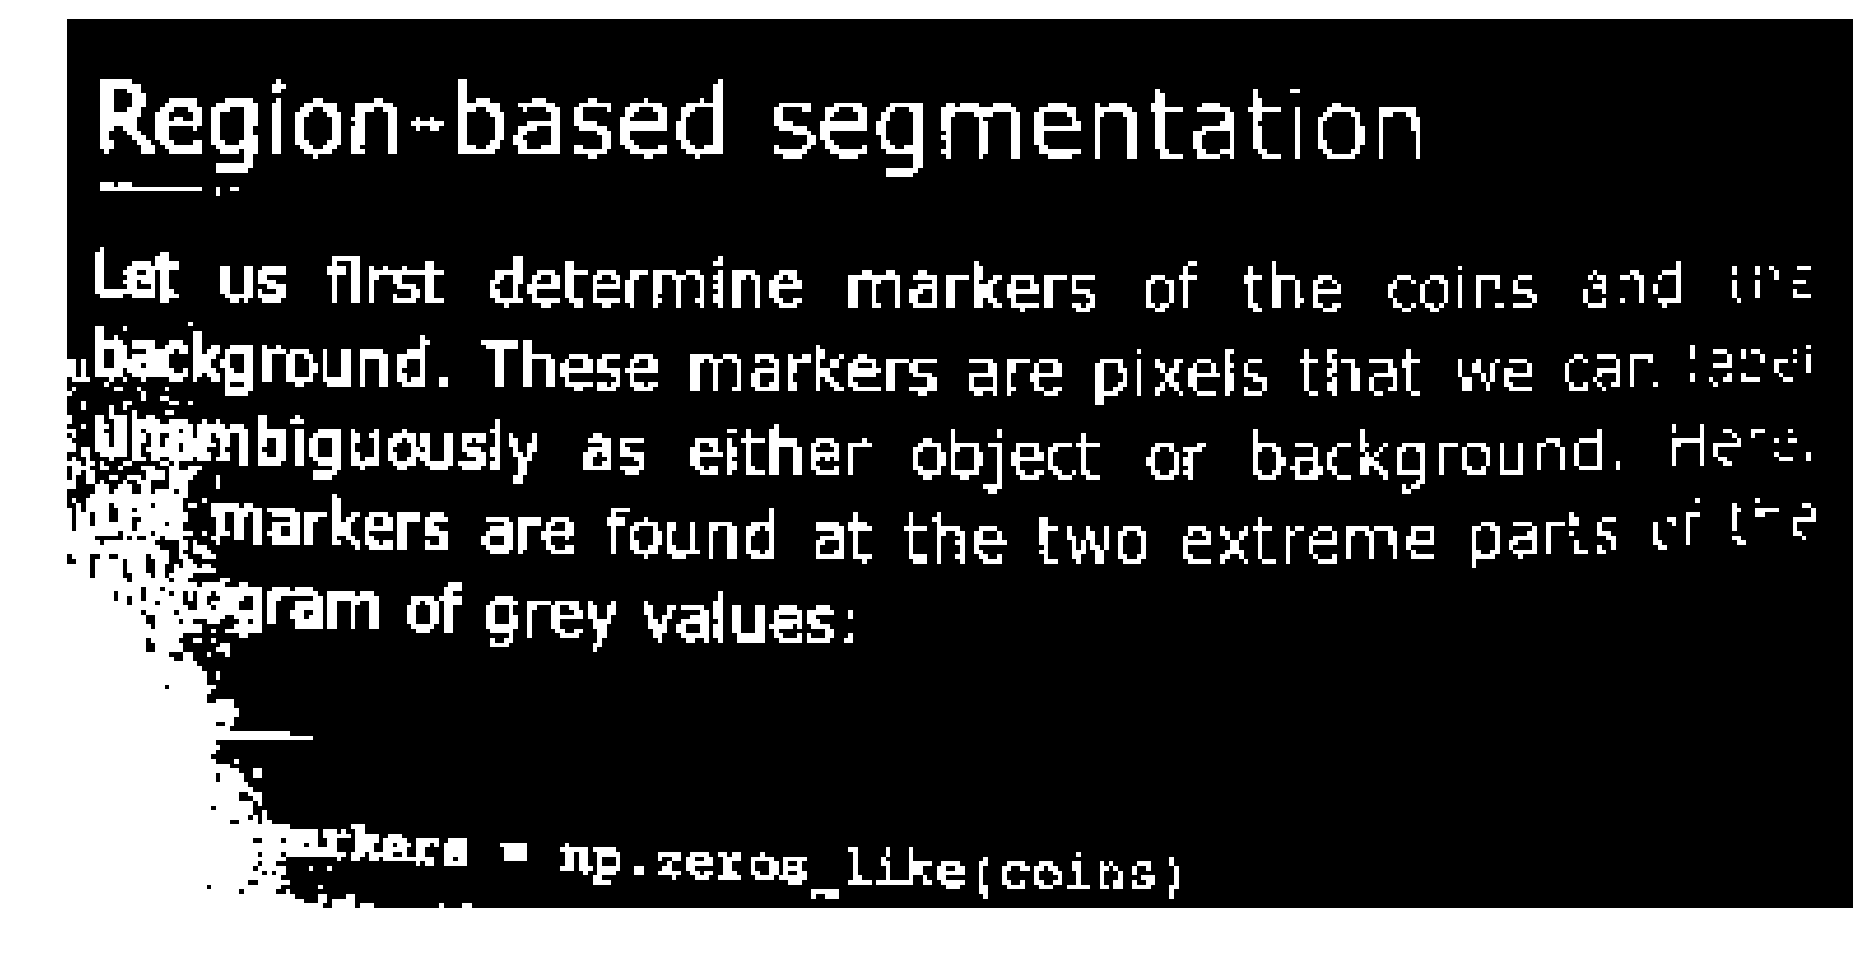

In [5]:
text_segmented = text < 100

image_show(text_segmented);

Not ideal results!  The shadow on the left creates problems; no single global value really fits.

What if we don't want to set the threshold every time?  There are several published methods which look at the histogram and choose what should be an optimal threshold without user input.  These are unsupervised.  

### Experimentation: unsupervised thresholding

Here we will experiment with a number of automatic thresholding methods available in scikit-image.  Because these require no input beyond the image itself, this is *unsupervised* segmentation.

These functions generally return the threshold value(s), rather than applying it to the image directly.

Try `otsu` and `li`, then take a look at `local` or `sauvola`.

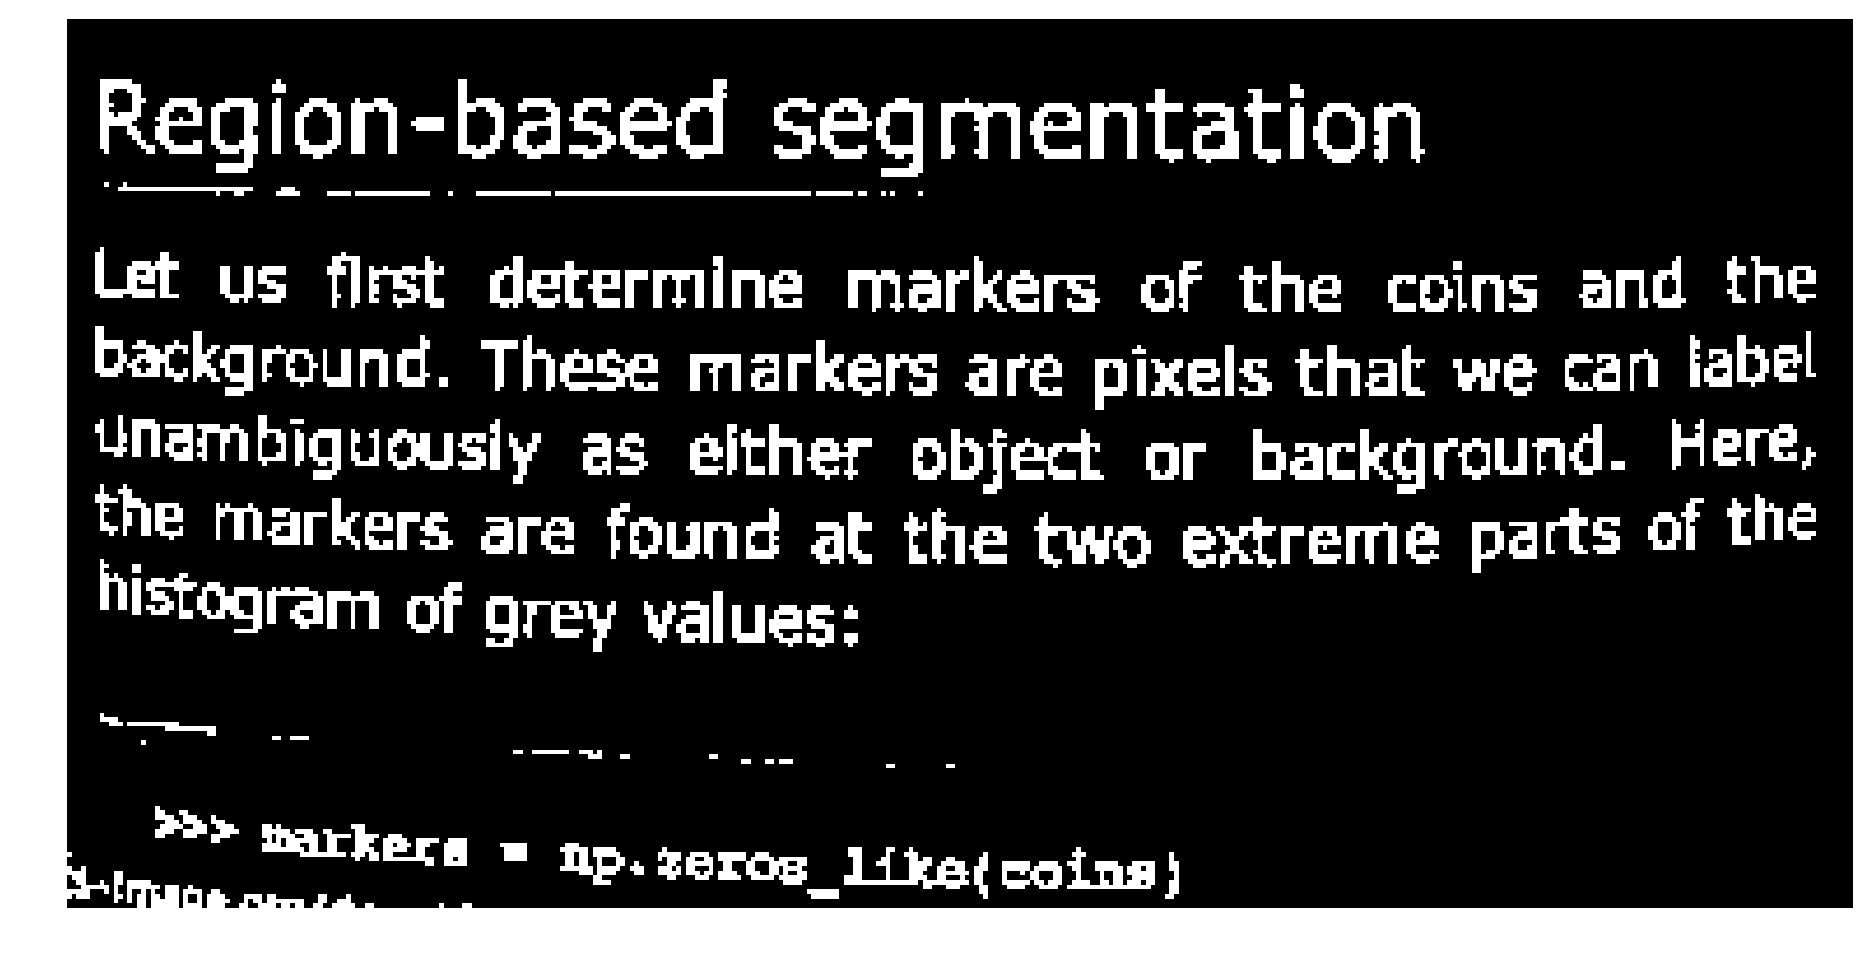

In [8]:
# text_threshold = filters.threshold_local(text, block_size=33)  # Hit tab with the cursor after the underscore, try several methods
text_threshold = filters.threshold_sauvola(text, window_size=(17, 65))
image_show(text < text_threshold);

## Supervised segmentation

Thresholding can be useful, but is rather basic and a high-contrast image will often limit its utility.  For doing more fun things - like removing part of an image - we need more advanced tools.

For this section, we will use the `astronaut` image and attempt to segment Eileen Collins' head using supervised segmentation.

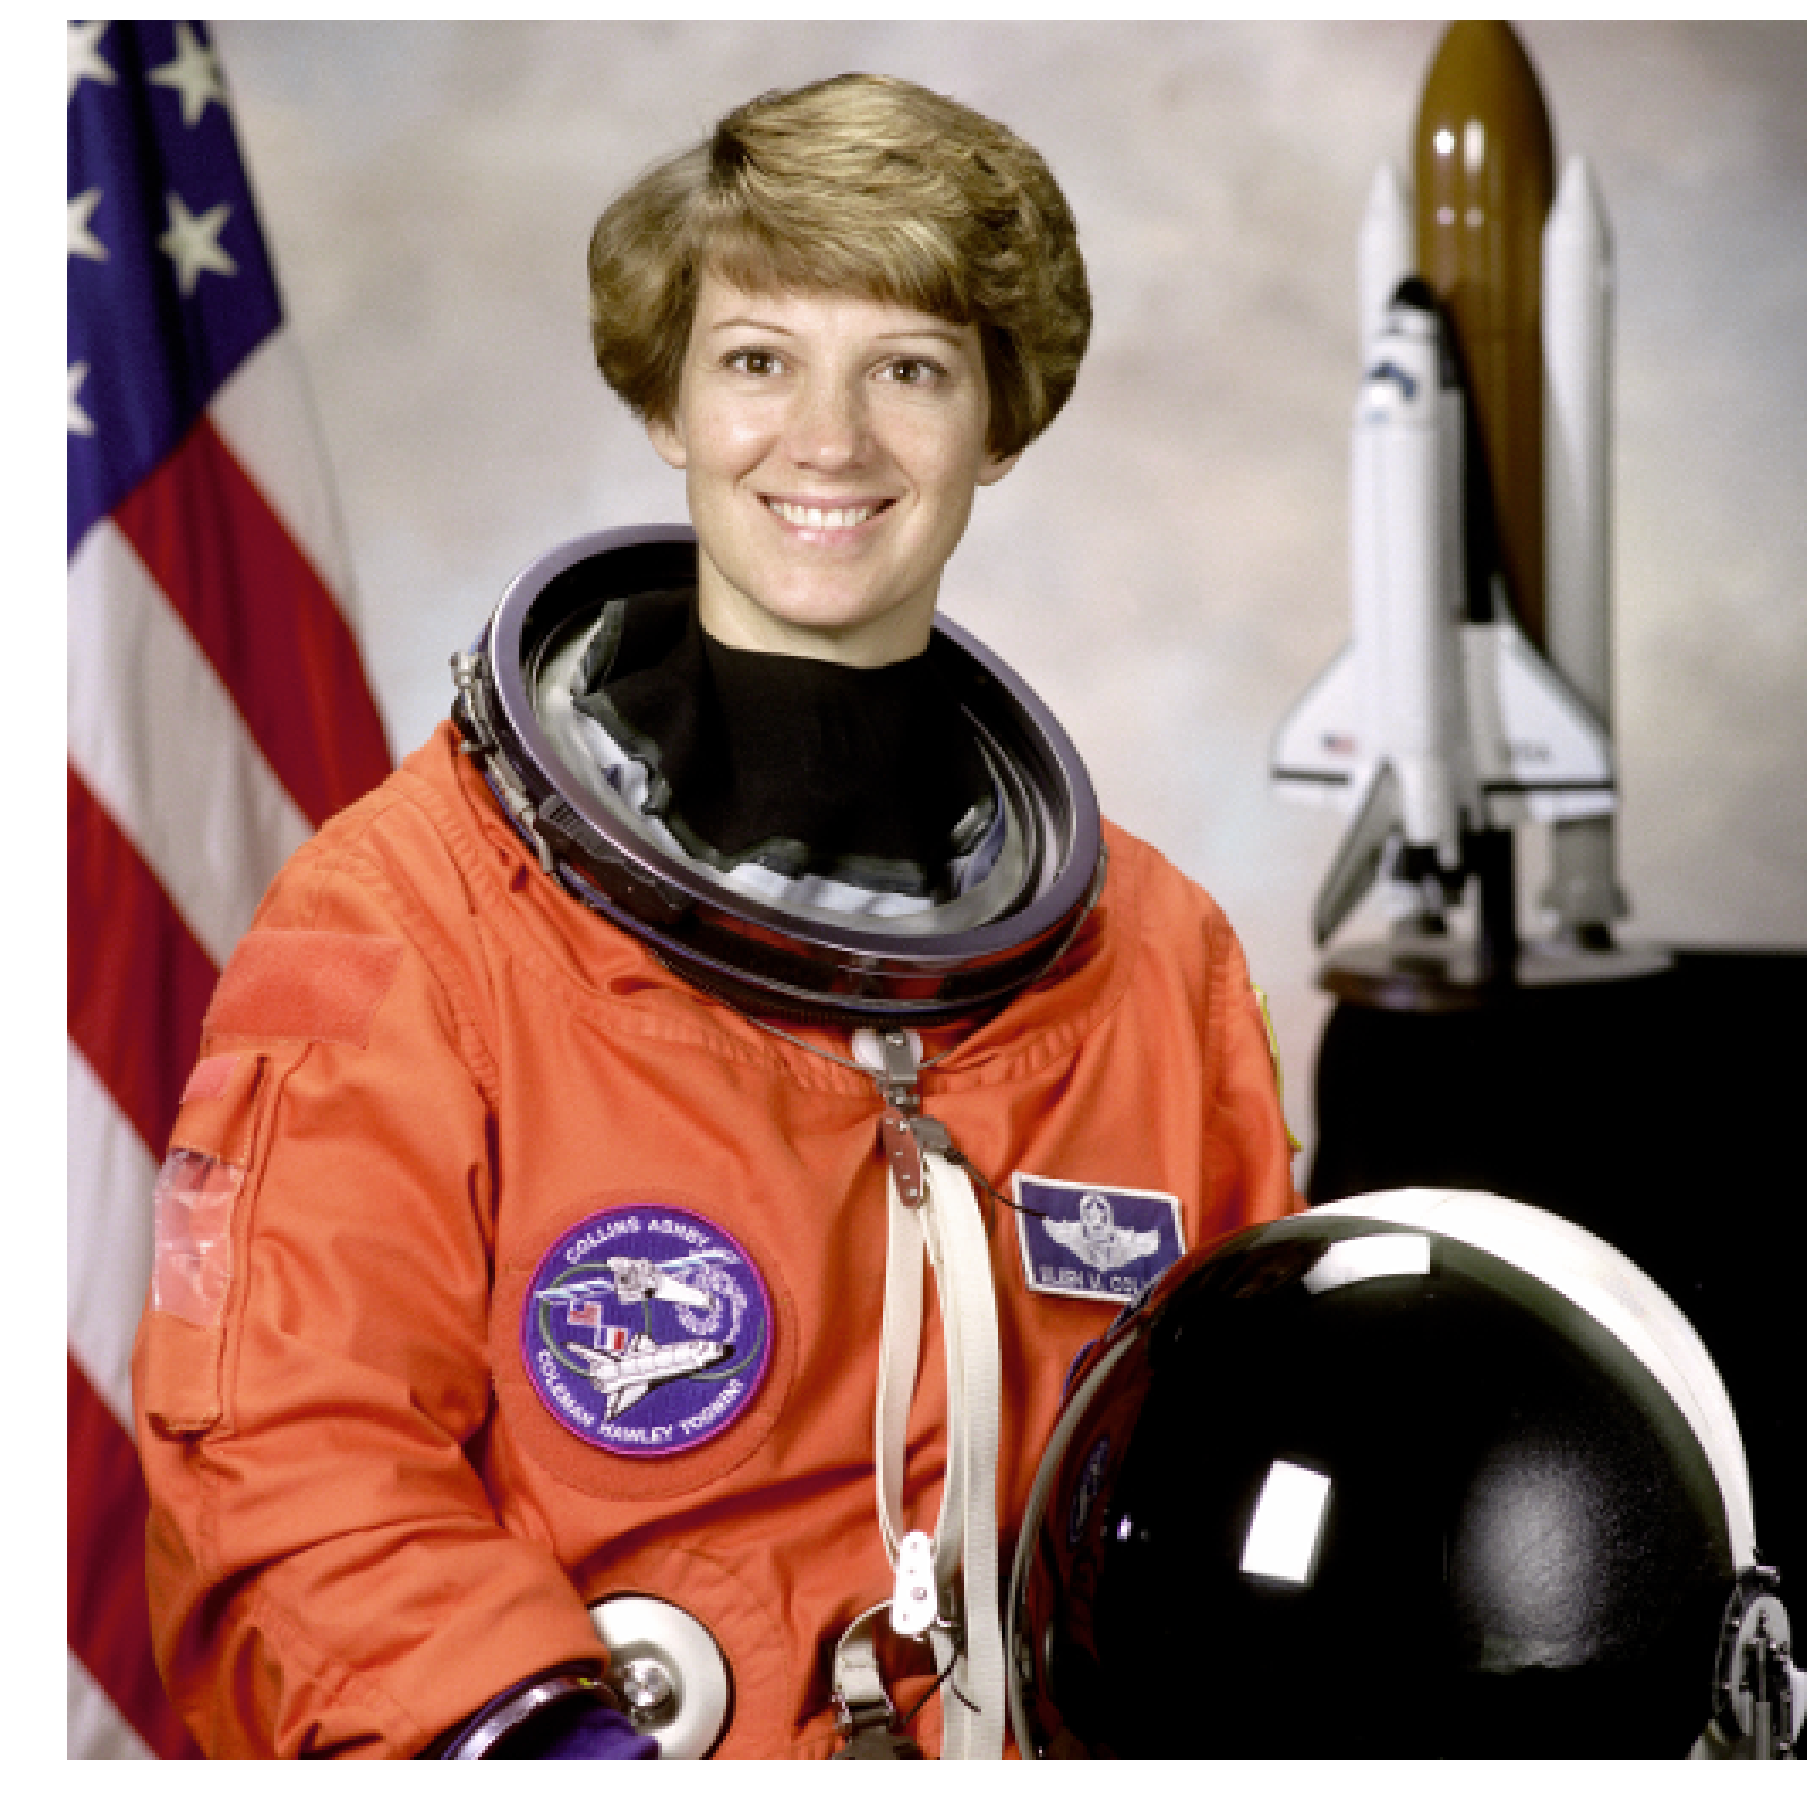

In [9]:
# Our source image
astronaut = data.astronaut()
image_show(astronaut);

The contrast is pretty good in this image for her head against the background, so we will simply convert to grayscale with `rgb2gray`.

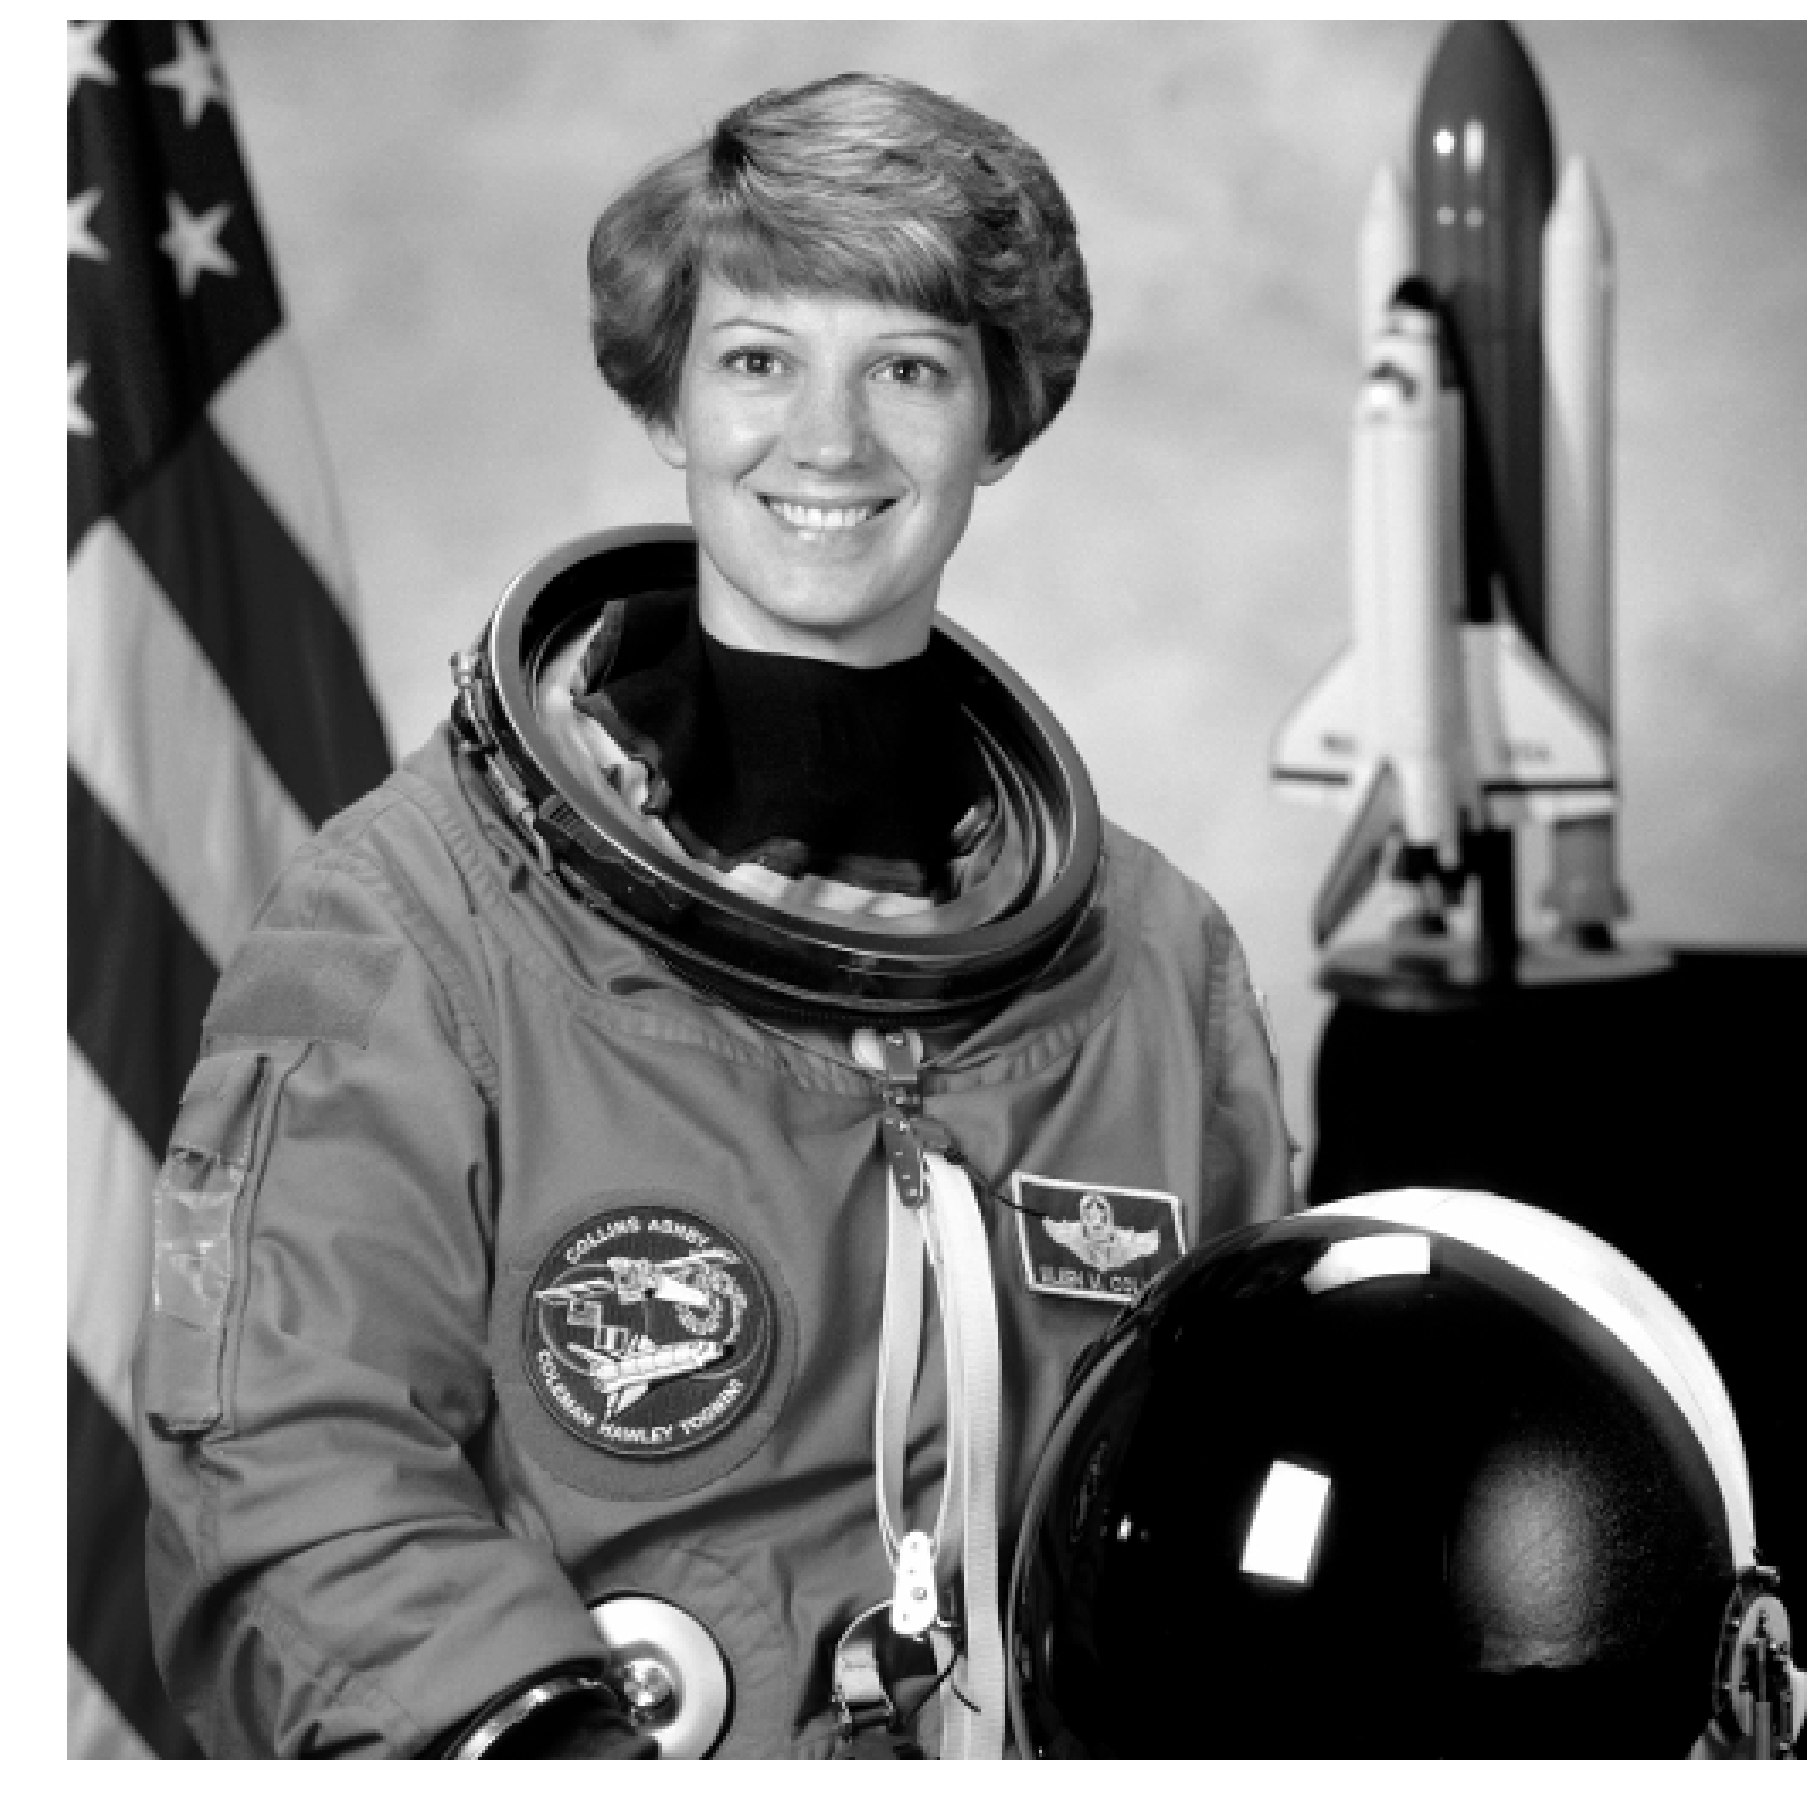

In [10]:
astronaut_gray = color.rgb2gray(astronaut)
image_show(astronaut_gray);

We will use two methods, which segment using very different approaches:

* **Active Contour**: Initializes using a user-defined contour or line, which then is attracted to edges and/or brightness.  Can be tweaked for many situations, but mixed contrast may be problematic.
* **Random walker**: Initialized using any labeled points, fills the image with the label that seems least distant from the origin point (on a path weighted by pixel differences).  Tends to respect edges or step-offs, and is surprisingly robust to noise.  Only one parameter to tweak.

### Active contour segmentation

We must have a set of initial parameters to 'seed' our segmentation this.  Let's draw a circle around the astronaut's head to initialize the snake.

This could be done interactively, with a GUI, but for simplicity we will start at the point [100, 220] and use a radius of 100 pixels.  Just a little trigonometry in this helper function...

In [11]:
def circle_points(resolution, center, radius):
    """
    Generate points defining a circle on an image.
    """
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [100, 220], 100)[:-1]

In [16]:
snake = seg.active_contour(astronaut_gray, points, alpha=0.1, beta=1)

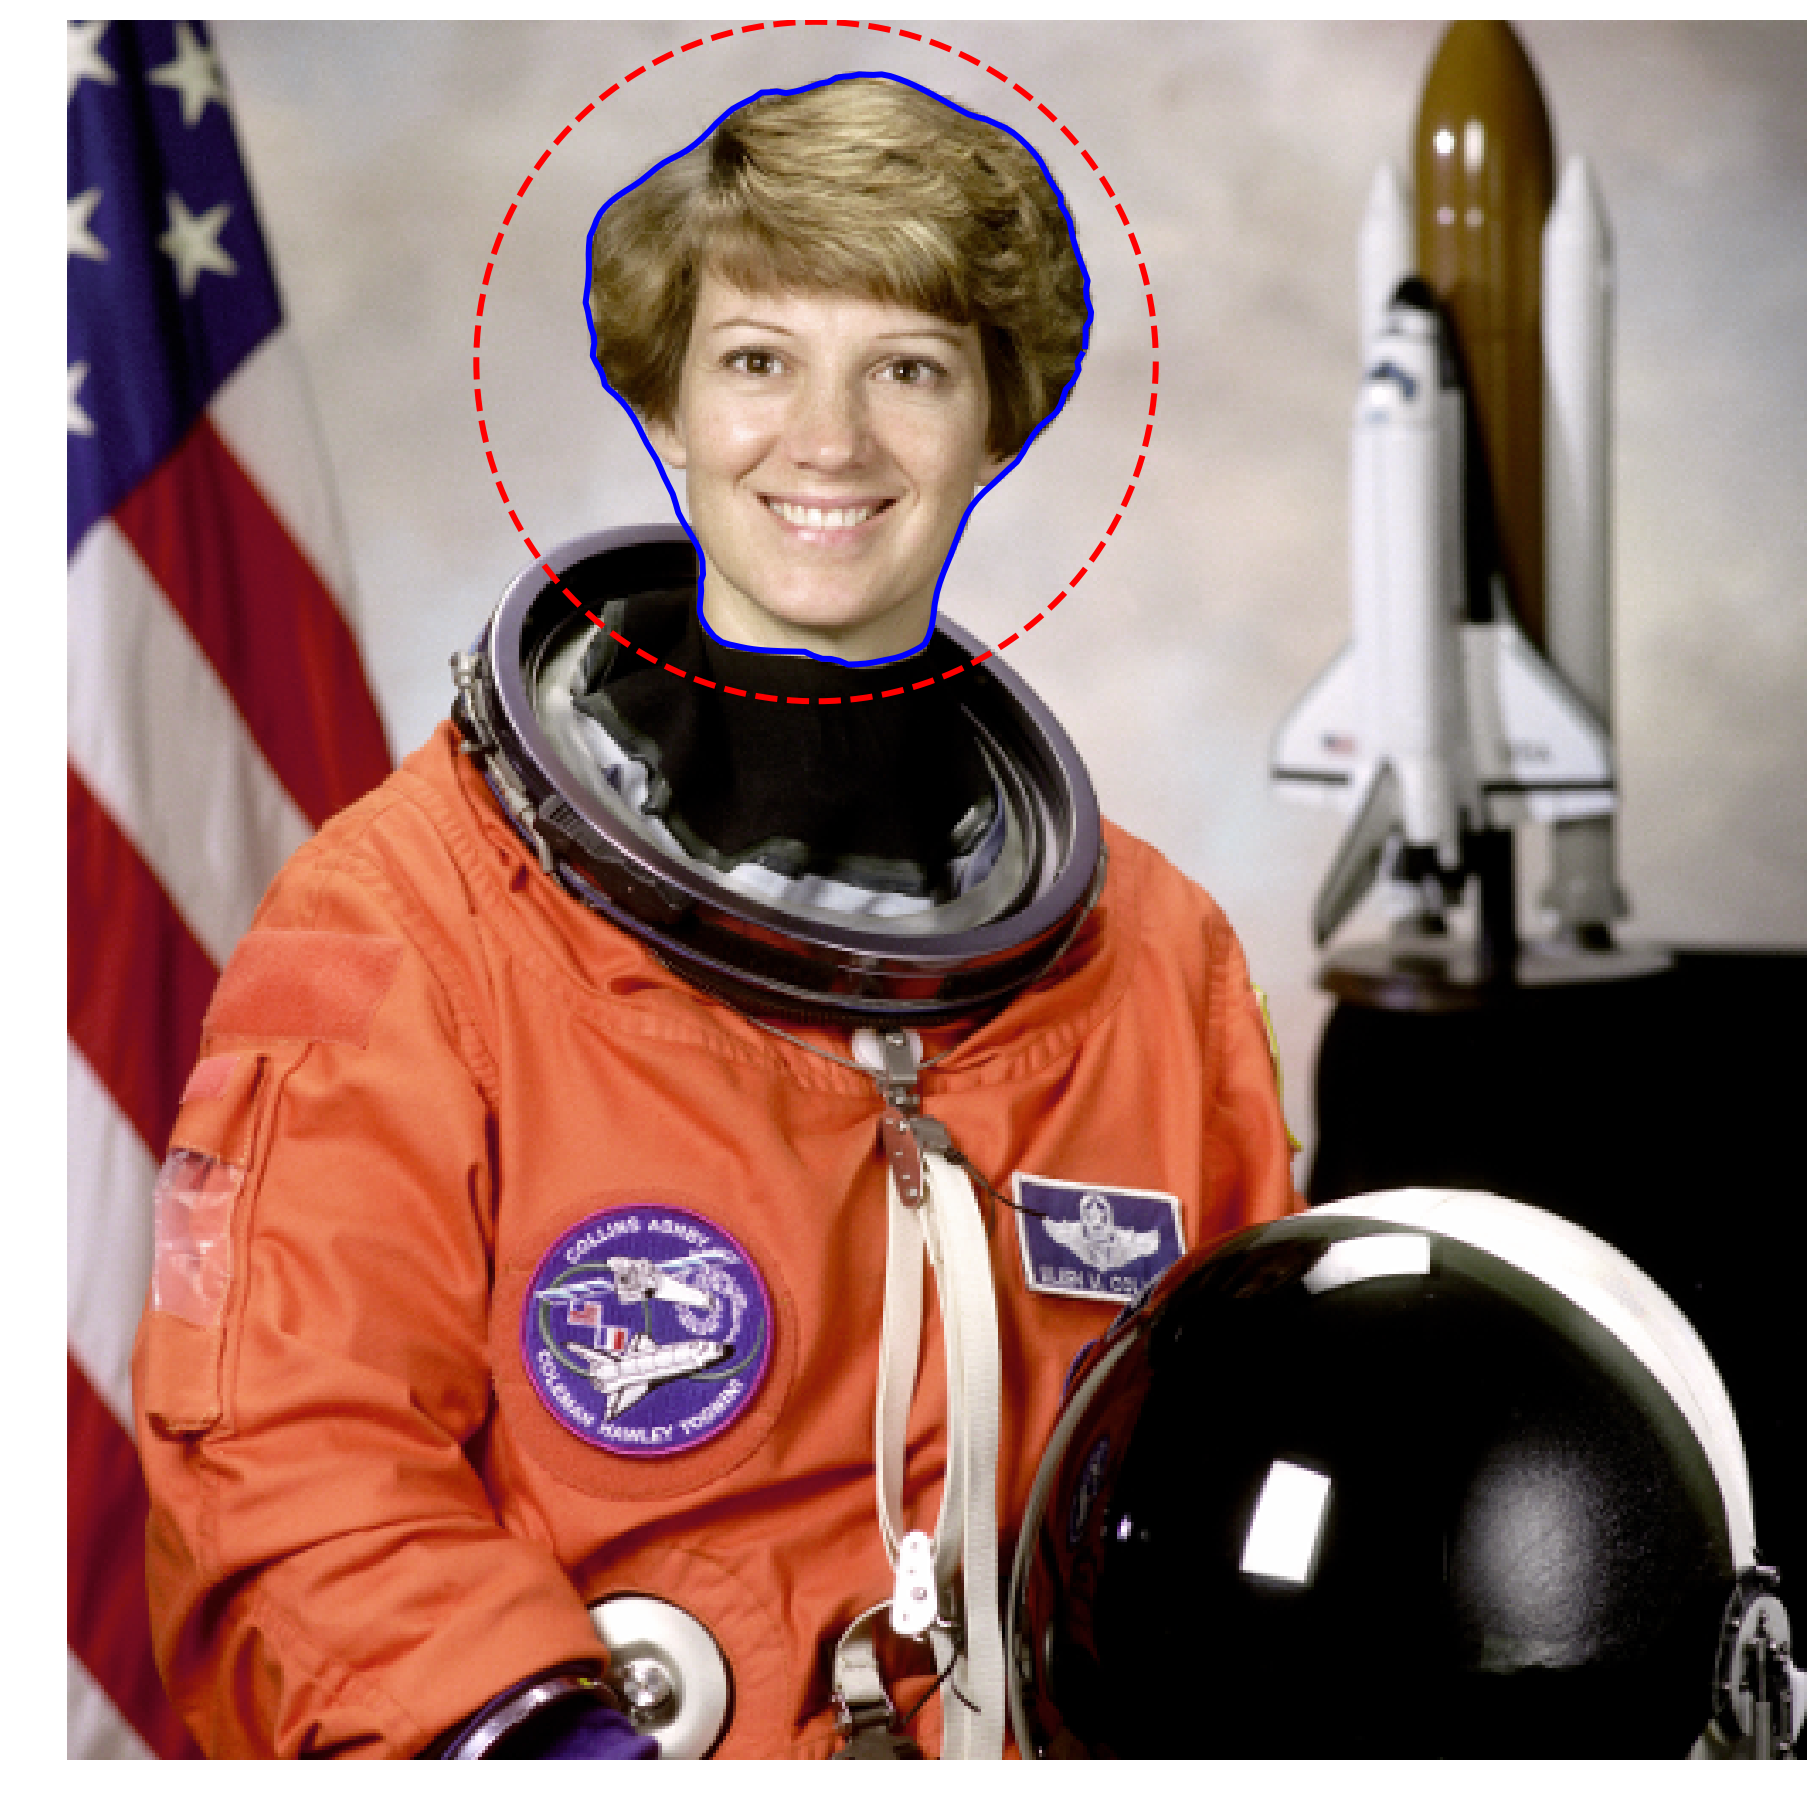

In [17]:
fig, ax = image_show(astronaut)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

### Random walker

One good analogy for random walker uses graph theory.  

* The distance from each pixel to its neighbors is weighted by how similar their values are; the more similar, the lower the cost is to step from one to another
* The user provides some seed points
* The algorithm finds the cheapest paths from each point to each seed value.  
* Pixels are labeled with the cheapest/lowest path.

We will re-use the seed values from our previous example.

In [19]:
astronaut_labels = np.zeros(astronaut_gray.shape, dtype=np.uint8)

The random walker algorithm expects a label image as input.  Any label above zero will be treated as a seed; all zero-valued locations will be filled with labels from the positive integers available.

There is also a masking feature where anything labeled -1 will never be labeled or traversed, but we will not use it here.

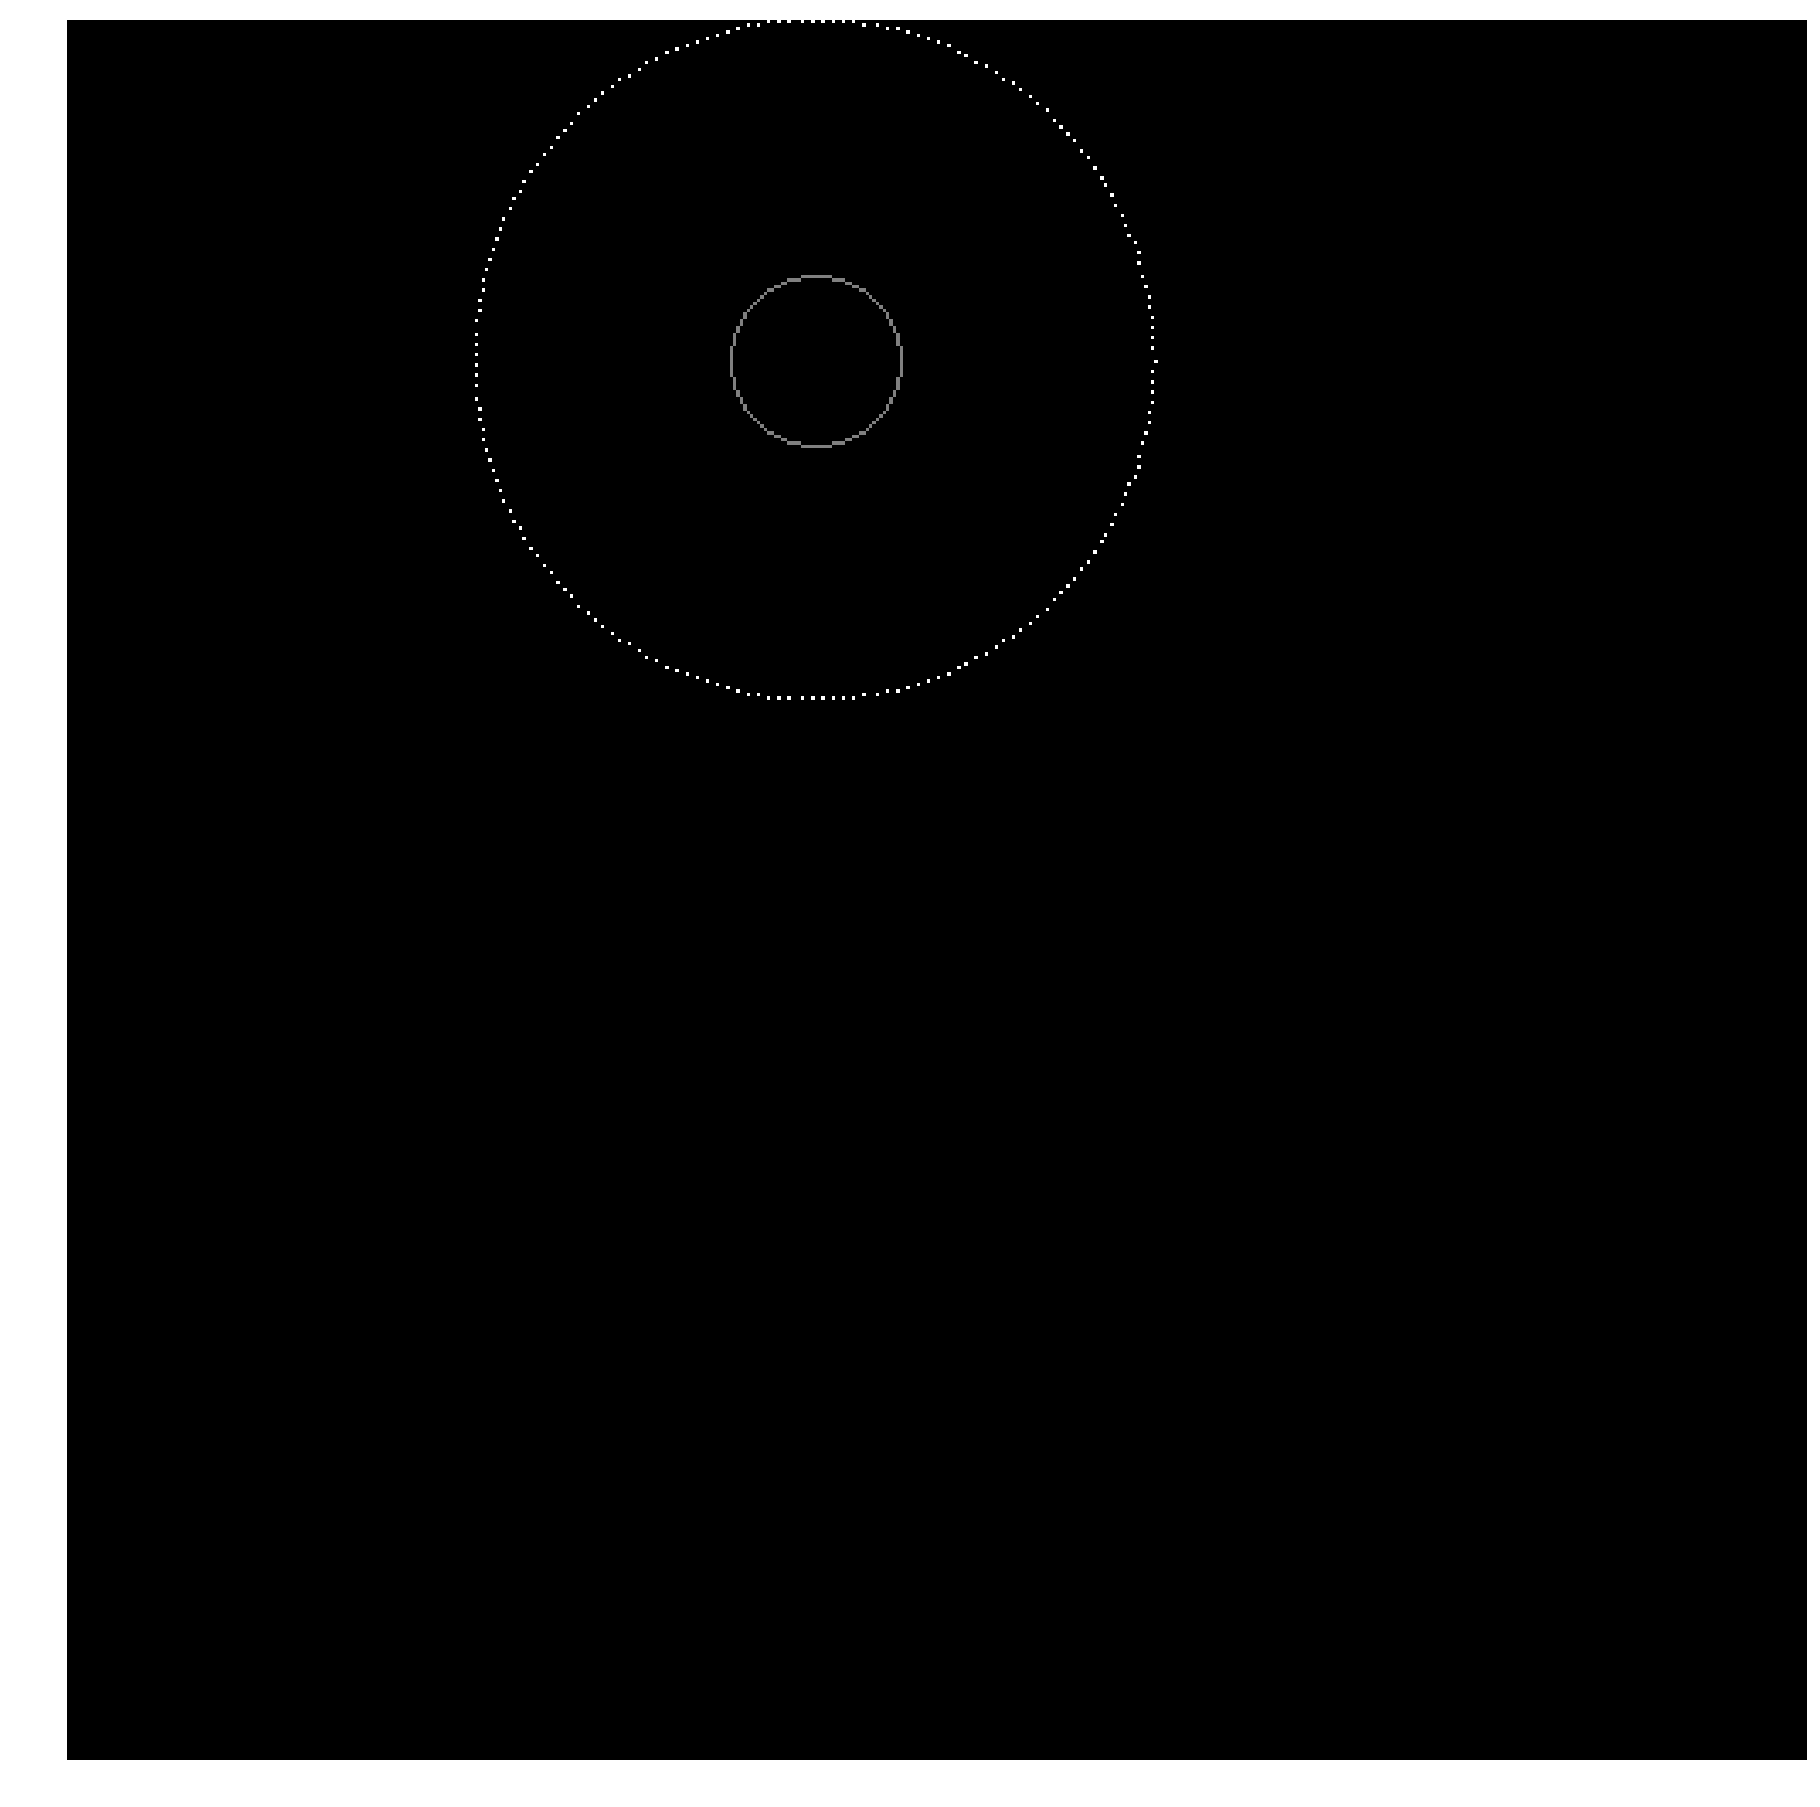

In [20]:
indices = draw.circle_perimeter(100, 220, 25)

astronaut_labels[indices] = 1
astronaut_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2

image_show(astronaut_labels);

In [25]:
astronaut_segmented = seg.random_walker(astronaut_gray, astronaut_labels, beta=2600)

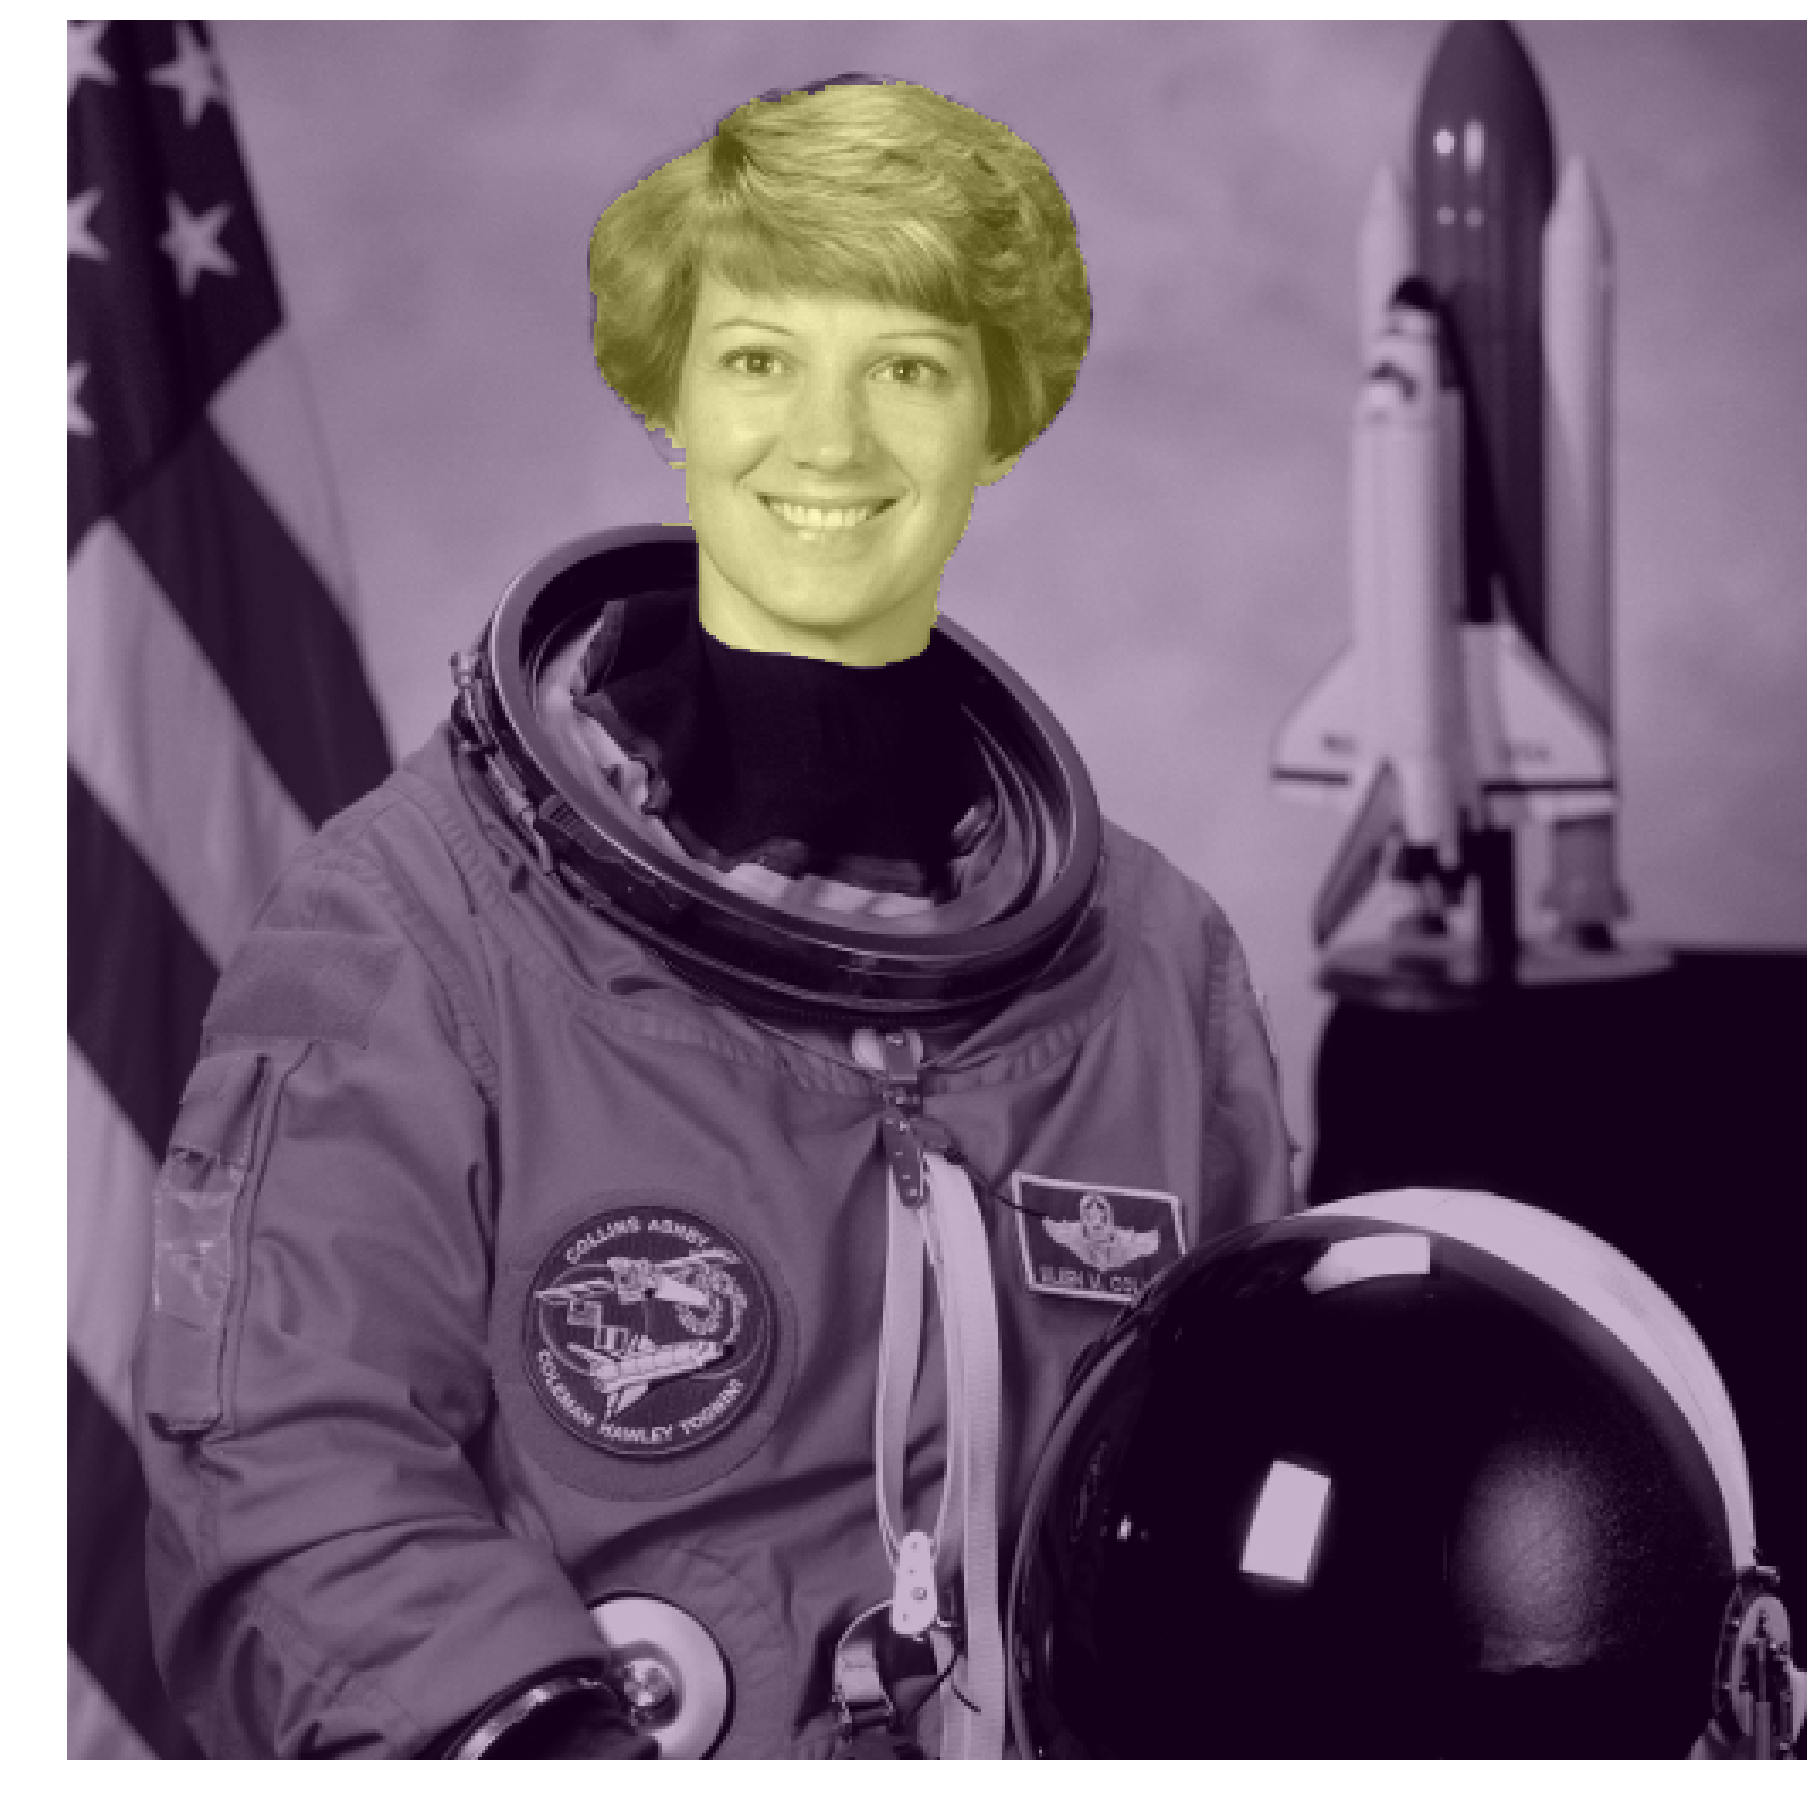

In [26]:
# Check our results
fig, ax = image_show(astronaut_gray)
ax.imshow(astronaut_segmented == 1, alpha=0.3);

## Unsupervised segmentation

Sometimes, human input is not possible or feasible - or, perhaps your images are so large that it is not feasible to consider all pixels simultaneously.  Unsupervised segmentation can then break the image down into several sub-regions, so instead of millions of pixels you have tens to hundreds of regions.

### SLIC

There are many analogies to machine learning in unsupervised segmentation.  Our first example directly uses a common machine learning algorithm under the hood - K-Means.

In [ ]:
# SLIC works in color, so we will use the original astronaut
astronaut_slic = seg.slic(astronaut)

In [ ]:
# label2rgb replaces each discrete label with the average interior color
image_show(color.label2rgb(astronaut_slic, astronaut, kind='avg'));

We've reduced this image from 512*512 = 262,000 pixels down to 100 regions!

And most of these regions make some logical sense.

### Chan-Vese

This algorithm iterates a level set, which allows it to capture complex and even disconnected features.  However, its result is binary - there will only be one region - and it requires a grayscale image.

This algorithm takes a few seconds to run.

In [ ]:
chan_vese = seg.chan_vese(astronaut_gray)

In [ ]:
fig, ax = image_show(astronaut_gray)
ax.imshow(chan_vese == 0, alpha=0.3);

Chan-Vese has a number of paremeters, which you can try out!  In the interest of time, we may move on.

### Felzenszwalb

This method oversegments an RGB image (requires color, unlike Chan-Vese) using another machine learning technique, a minimum-spanning tree clustering.  The number of segments is not guaranteed and can only be indirectly controlled via `scale` parameter.

In [ ]:
astronaut_felzenszwalb = seg.felzenszwalb(astronaut)  # Color required

In [ ]:
image_show(astronaut_felzenszwalb);

Whoa, lots of regions!  How many is that?

In [ ]:
# Find the number of unique labels


Let's see if they make sense; label them with the region average (see above with SLIC)

In [ ]:
astronaut_felzenszwalb_colored =  # Your code here

image_show(astronaut_felzenszwalb_colored);

Actually reasonable small regions.  If we wanted fewer regions, we could change the `scale` parameter (try it!) or start here and combine them.

This approach is sometimes called **oversegmentation**.

But when there are too many regions, they must be combined somehow.

## Combining regions with a Region Adjacency Graph (RAG)

Remember how the concept behind random walker was functionally looking at the difference between each pixel and its neighbors, then figuring out which were most alike?  A RAG is essentially the same, except between regions.

We have RAGs now in scikit-image, but we have to import *from the future*; this functionality is exposed in the `future.graph` submodule meaning it is stable and robust enough to ship, but the API may change.

In [ ]:
import skimage.future.graph as graph

rag = graph.rag_mean_color(astronaut, astronaut_felzenszwalb + 1)

Now we show just one application of a very useful tool - `skimage.measure.regionprops` - to determine the centroid of each labeled region and pass that to the graph.  

`regionprops` has many, many other uses; see the API documentation for all of the features that can be quantified per-region!  
http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [ ]:
import skimage.measure as measure

# Regionprops ignores zero, but we want to include it, so add one
regions = measure.regionprops(astronaut_felzenszwalb + 1)  

# Pass centroid data into the graph
for region in regions:
    rag.node[region['label']]['centroid'] = region['centroid']

`display_edges` is a helper function to assist in visualizing the graph.

In [ ]:
def display_edges(image, g, threshold):
    """Draw edges of a RAG on its image
 
    Returns a modified image with the edges drawn.Edges are drawn in green
    and nodes are drawn in yellow.
 
    Parameters
    ----------
    image : ndarray
        The image to be drawn on.
    g : RAG
        The Region Adjacency Graph.
    threshold : float
        Only edges in `g` below `threshold` are drawn.
 
    Returns:
    out: ndarray
        Image with the edges drawn.
    """
    image = image.copy()
    for edge in g.edges():
        n1, n2 = edge
 
        r1, c1 = map(int, rag.node[n1]['centroid'])
        r2, c2 = map(int, rag.node[n2]['centroid'])
 
        line  = draw.line(r1, c1, r2, c2)
        circle = draw.circle(r1,c1,2)
 
        if g[n1][n2]['weight'] < threshold :
            image[line] = 0,255,0
        image[circle] = 255,255,0
 
    return image

In [ ]:
# All edges are drawn with threshold at infinity
edges_drawn_all = display_edges(astronaut_felzenszwalb_colored, rag, np.inf)
image_show(edges_drawn_all);

Try a range of thresholds out, see what happens.

In [ ]:
threshold =  # Experiment

edges_drawn_few = display_edges(astronaut_felzenszwalb_colored, rag, threshold)
image_show(edges_drawn_few);

#### Finally, cut the graph

Once you are happy with the (dis)connected regions above, the graph can be cut to merge the regions which are still connected.

In [ ]:
final_labels = graph.cut_threshold(astronaut_felzenszwalb + 1, rag, threshold)
final_label_rgb = color.label2rgb(final_labels, astronaut, kind='avg')

image_show(final_label_rgb);

How many regions exist now?

In [ ]:
np.unique(final_labels).size

## Exercise: Cat picture

The data directory also has an excellent image of Stéfan's cat, Chelsea.  With what you've learned, can you segment the cat's nose?  How about the eyes?  Why is the eye particularly challenging?

Hint: the cat's nose is located close to [240, 270] and the right eye center is near [110, 172] in row, column notation.

In [ ]:
fig, ax = image_show(data.chelsea())

ax.plot(270, 240, marker='o', markersize=15, color="g")
ax.plot(172, 110, marker='o', markersize=15, color="r");